In [5]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.callbacks import Callback,ModelCheckpoint
from keras.optimizers import SGD
import copy
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [6]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


In [7]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


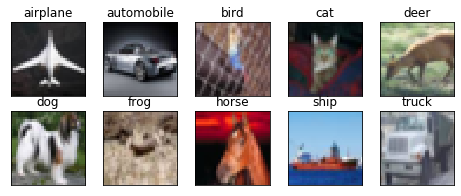

In [8]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
    
    
    

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [13]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
mean_train = np.mean(train_features,axis = 0)

def cout_out_function(mean_train, p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        # below i have peplaced the cutout area with th mean of the image pixels
        input_img[top:top + h, left:left + w, :] = mean_train[top:top + h, left:left + w, :]

        return input_img

    return eraser


In [15]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [20]:
# Define the model
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(32, (1, 1)))


model1.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Conv2D(32, (1, 1)))


model1.add(Conv2D(128, (3, 3),kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(256, (3, 3),kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Conv2D(10, (1, 1),name = "last_conv_layer"))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model_lr_finder = copy.deepcopy(model1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`


In [21]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

### Total params: 455,370

## Ran Learning Rate finder and 0.01 seems to be a good Learning Rate for the model

In [22]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/batch_size))
#model4.fit(x_train, y_train, callbacks=[lr_finder] )

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function = cout_out_function(mean_train))


# train the model
start = time.time()
# Train the model
model_info = model_lr_finder.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=1, callbacks=[lr_finder])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390, epochs=50)`




Epoch 1/50
371/390 [===========================>..] - ETA: 1s - loss: 3.1534 - acc: 0.2547Model took 29.86 seconds to train


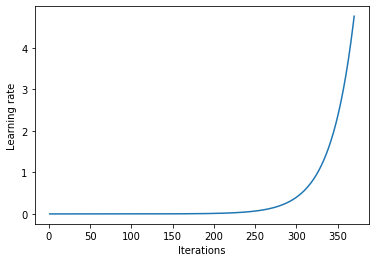

In [23]:
lr_finder.plot_lr()

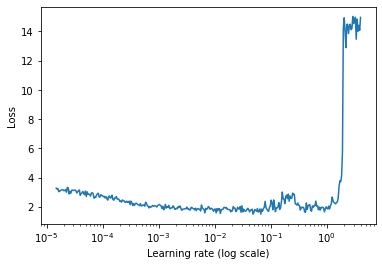

In [24]:
lr_finder.plot()

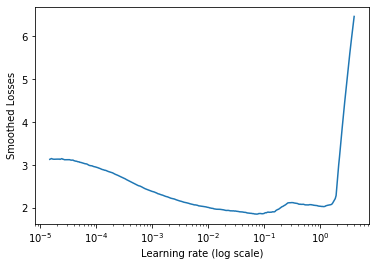

In [25]:
lr_finder.plot_smoothed_loss()

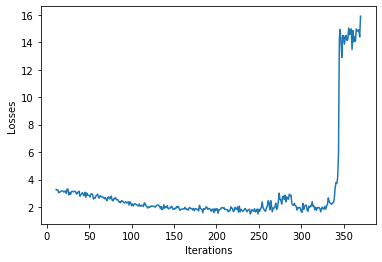

In [26]:
lr_finder.plot_loss()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`


Model took 1264.25 seconds to train


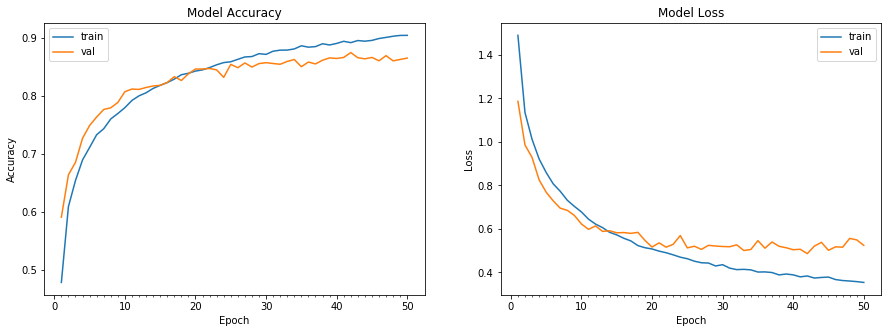

Accuracy on test data is: 86.55


In [27]:

def scheduler(epoch, lr):
  return 0.01




mcp_save = ModelCheckpoint('./improve_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')


batch_size = 128

#model4.fit(x_train, y_train, callbacks=[lr_finder] )

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function = cout_out_function(mean_train))


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=0, callbacks = [LearningRateScheduler(scheduler, verbose=0),mcp_save])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))


### Achieved 86.55 % accuracy

### Ran for 50 more epochs and achieved 87.88 %

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  del sys.path[0]


Model took 1259.48 seconds to train


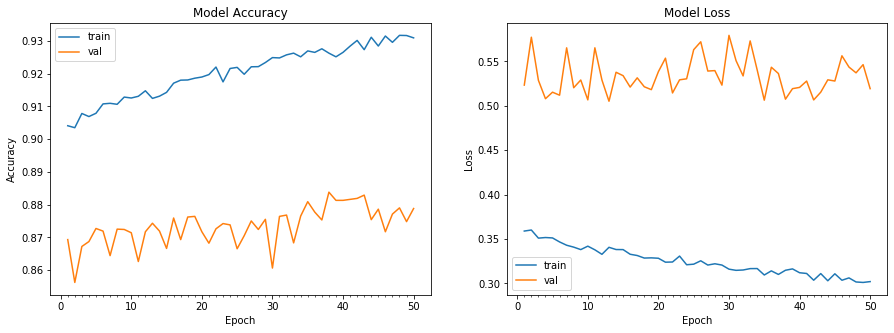

Accuracy on test data is: 87.88


In [28]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function = cout_out_function(mean_train))


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (X_test, Y_test), verbose=0, callbacks = [LearningRateScheduler(scheduler, verbose=0), mcp_save])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
model1.load_weights("cutout_model.hdf5")

In [30]:
print("maximum validation accuracy {}".format(max(model_info.history['val_acc'])))

maximum validation accuracy 0.8838


In [0]:
import cv2
def get_heat_map_images(img, model, conv_layer,channels, class_idx = None):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)
  preds = model.predict(x)
  if not class_idx:
    class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  grads = K.gradients(class_output, conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  img = np.uint8(255 * img)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  b,g,r = cv2.split(superimposed_img)   
  superimposed_img = cv2.merge([r,g,b])
  return img, superimposed_img

In [32]:
test_features.shape

(10000, 32, 32, 3)

In [33]:
test_labels.shape

(10000, 10)

In [0]:
temp = next(datagen.flow(test_features, batch_size=len(test_features)))

In [36]:
temp.shape

(10000, 32, 32, 3)

In [37]:
model1.predict_generator(datagen.flow(test_features, batch_size=int(len(test_features)/100), shuffle = False)).shape

(10000, 10)

## Extract the index of misclassified images

In [38]:
y_pred = np.argmax(model1.predict_generator(datagen.flow(test_features, batch_size=int(len(test_features)/100), shuffle = False)), axis = 1)
y_true = np.argmax(test_labels, axis = 1)
misclassified_index = [ind for ind,(i,j) in enumerate(zip(y_pred,y_true)) if i != j]
len(misclassified_index)

6600

# Plotted grad cam of misclassified images.

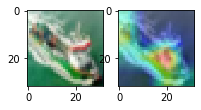

In [107]:
last_conv_layer = model1.get_layer("last_conv_layer")
_, superimposed_img = get_heat_map_images(test_features[misclassified_index[5]], model1,last_conv_layer, 3 )
fig=plt.figure(figsize=(3, 3))
fig.add_subplot(1,2, 1)
plt.imshow(test_features[misclassified_index[5]])  
fig.add_subplot(1,2, 2)

plt.imshow(superimposed_img)


## Plot of 25 mis classfied images with label of mis-classification and actual label

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


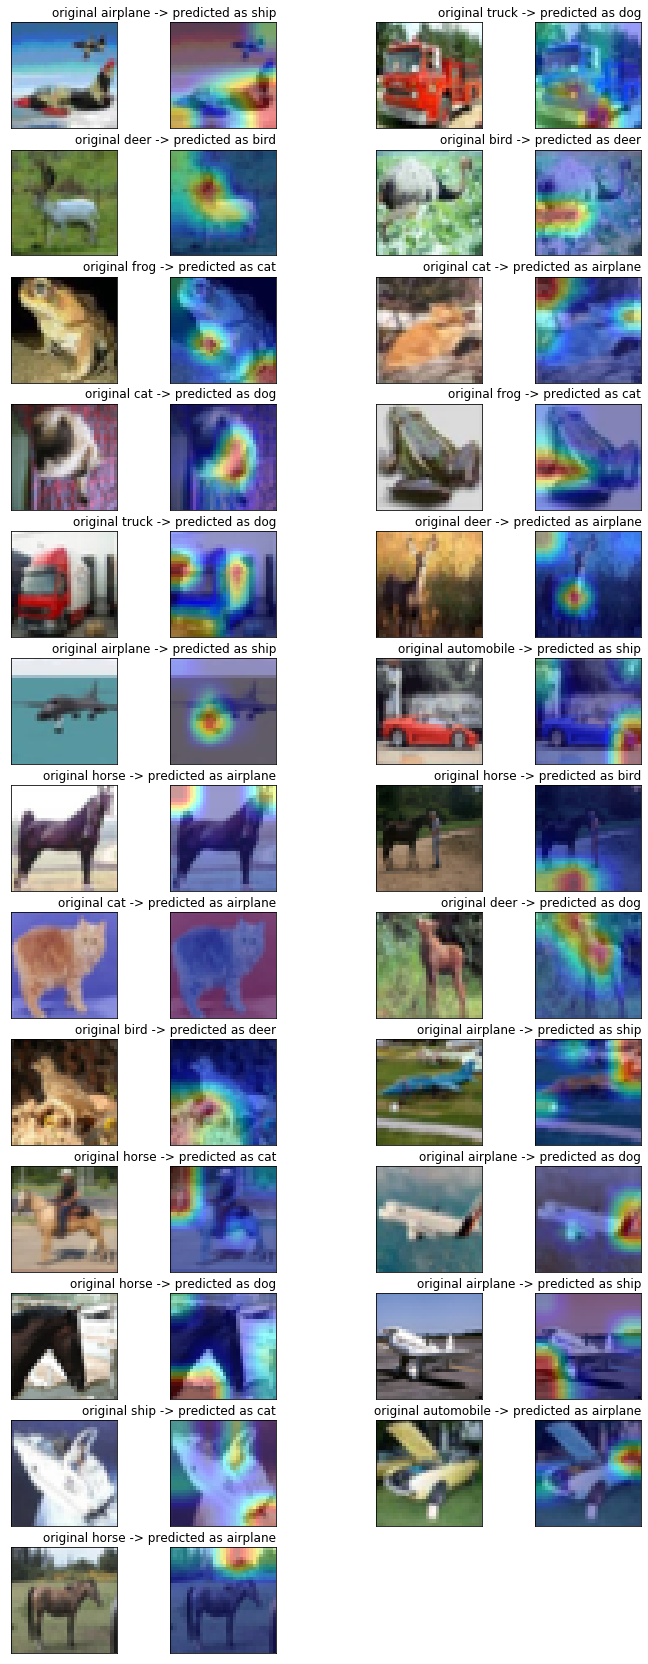

In [116]:


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 30))
outer = gridspec.GridSpec(13, 2, wspace=0.2, hspace=0.2)

for i,ind in  enumerate(misclassified_index[-25:]):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    
    ax = plt.Subplot(fig, inner[0])
    t = ax.imshow(test_features[ind])
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

    _, superimposed_image = get_heat_map_images(test_features[ind], model1,last_conv_layer, 3 )
    ax = plt.Subplot(fig, inner[1])
    t = ax.imshow(superimposed_image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('original {} -> predicted as {}'.format(class_names[y_true[ind]],class_names[y_pred[ind]]),loc = "right")
    fig.add_subplot(ax)


fig.show()